# Fraud Detection in Electricity and Gas Consumption Challenge

This is the code for a ML competition taken in Zindi, to detect fraudulent transactions in gas and electricity consumption in Tunisia. Click here for more details about the project [here](https://zindi.africa/learn/fraud-detection-in-electricity-and-gas-consumption-challenge-tutorial).

This notebook covers:
- **Preprocessing:** The data cleaning steps taken.
- **Exploratory Data Analysis (EDA):** Any EDA that was performed to derive insights from the data. 
- **Feature Engineering:** Feature Engineering steps that were taken to create features, based on RFM - recency, frequency, monetary, based on the EDA and domain knowledge. 
- **Modelling:** Different models were applied to the data and the performance metrics were assessed. The models were stacked to see if a stacked, ensemble model performs better than a stand-alone model.
- **Testing:** The best performing model (in this case, Light GBM) was then tested on unseen data to assess performance in a production scenario.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm
import seaborn as sns
from lightgbm import LGBMClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import datetime
import math as math
from scipy.stats import randint, uniform
from sklearn.feature_selection import RFE

import warnings
warnings.simplefilter('ignore')

Using TensorFlow backend.
/opt/python/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/python/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/python/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/python/anaconda3/lib/python3.6/site-packages/tensorflo

## Read the Data

In [2]:
client_train = pd.read_csv('client_train.csv', low_memory=False)
invoice_train = pd.read_csv('invoice_train.csv', low_memory=False)

client_test = pd.read_csv('client_test.csv', low_memory=False)
invoice_test = pd.read_csv('invoice_test.csv', low_memory=False)
sample_submission = pd.read_csv('SampleSubmission.csv', low_memory=False)

## Data Understanding

In [3]:
#compare size of the various datasets
print(client_train.shape, invoice_train.shape, client_test.shape, invoice_train.shape)

(135493, 6) (4476749, 16) (58069, 5) (4476749, 16)


In [4]:
#print top rows of dataset
invoice_train.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [5]:
#print top rows of dataset
client_train.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


In [6]:
#Get a summary for all numerical columns
invoice_train.describe()

,tarif_type,counter_number,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number
count,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06
mean,2.012804e+01,1.230587e+11,1.724884e+02,7.321702e+00,1.003040e+00,4.109795e+02,1.093225e+02,2.030620e+01,5.292588e+01,1.776700e+04,1.834970e+04,4.483095e+01
std,1.347256e+01,1.657267e+12,1.338871e+02,1.571654e+00,3.083466e-01,7.573080e+02,1.220123e+03,1.574239e+02,8.754725e+02,4.036693e+04,4.095321e+04,3.128335e+03
min,8.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.100000e+01,1.211080e+05,5.000000e+00,6.000000e+00,1.000000e+00,7.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.791000e+03,2.056000e+03,4.000000e+00
50%,1.100000e+01,4.945610e+05,2.030000e+02,8.000000e+00,1.000000e+00,2.740000e+02,0.000000e+00,0.000000e+00,0.000000e+00,7.690000e+03,8.192000e+03,4.000000e+00
75%,4.000000e+01,1.115161e+06,2.070000e+02,9.000000e+00,1.000000e+00,6.000000e+02,0.000000e+00,0.000000e+00,0.000000e+00,2.166000e+04,2.234300e+04,4.000000e+00
max,4.500000e+01,2.798115e+13,6.000000e+02,4.130000e+02,5.000000e+01,9.999100e+05,9.990730e+05,6.449200e+04,5.479460e+05,2.800280e+06,2.870972e+06,6.366240e+05


In [7]:
#Get a summary for all numerical columns
client_train.describe()

,disrict,client_catg,region,target
count,135493.000000,135493.000000,135493.000000,135493.000000
mean,63.511222,11.512506,206.159809,0.055841
std,3.354400,4.423761,104.207044,0.229614
min,60.000000,11.000000,101.000000,0.000000
25%,62.000000,11.000000,103.000000,0.000000
50%,62.000000,11.000000,107.000000,0.000000
75%,69.000000,11.000000,307.000000,0.000000
max,69.000000,51.000000,399.000000,1.000000


In [8]:
#Get concise information of each column in dataset
invoice_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   client_id             object
 1   invoice_date          object
 2   tarif_type            int64 
 3   counter_number        int64 
 4   counter_statue        object
 5   counter_code          int64 
 6   reading_remarque      int64 
 7   counter_coefficient   int64 
 8   consommation_level_1  int64 
 9   consommation_level_2  int64 
 10  consommation_level_3  int64 
 11  consommation_level_4  int64 
 12  old_index             int64 
 13  new_index             int64 
 14  months_number         int64 
 15  counter_type          object
dtypes: int64(12), object(4)
memory usage: 546.5+ MB


In [9]:
#Get concise information of each column in dataset
client_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   disrict        135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB


In [10]:
#Getting unique values on the invoice train data
for col in invoice_train.columns:
    print(f"{col} - {invoice_train[col].nunique()}")

client_id - 135493
invoice_date - 8275
tarif_type - 17
counter_number - 201893
counter_statue - 12
counter_code - 42
reading_remarque - 8
counter_coefficient - 16
consommation_level_1 - 8295
consommation_level_2 - 12576
consommation_level_3 - 2253
consommation_level_4 - 12075
old_index - 155648
new_index - 157980
months_number - 1370
counter_type - 2


In [11]:
#Getting unique values on the invoice train data
for col in client_train.columns:
    print(f"{col} - {client_train[col].nunique()}")

disrict - 4
client_id - 135493
client_catg - 3
region - 25
creation_date - 8088
target - 2


In [12]:
#check for missing values
invoice_train.isnull().sum()

client_id               0
invoice_date            0
tarif_type              0
counter_number          0
counter_statue          0
counter_code            0
reading_remarque        0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
consommation_level_4    0
old_index               0
new_index               0
months_number           0
counter_type            0
dtype: int64

In [13]:
#check for missing values
client_train.isnull().sum()

disrict          0
client_id        0
client_catg      0
region           0
creation_date    0
target           0
dtype: int64

No missing values in train set

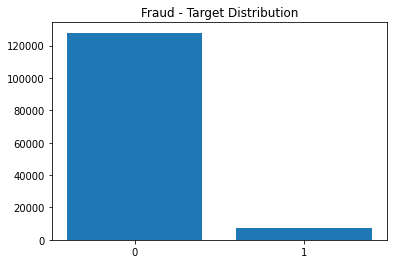

In [14]:
#Visualize fraudulent activities
fraudactivities = client_train.groupby(['target'])['client_id'].count()
plt.bar(x=fraudactivities.index, height=fraudactivities.values, tick_label = [0,1])
plt.title('Fraud - Target Distribution')
plt.show()

Target is highly imbalanced with fewer cases of fraudulent activities

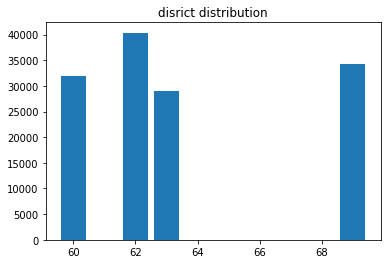

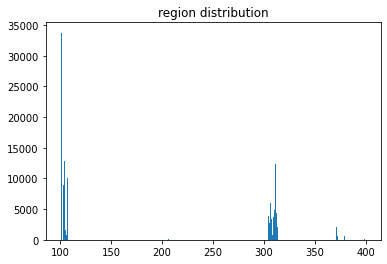

In [15]:
#Visualize client distribution across districts and regions
for col in ['disrict','region']:
    region = client_train.groupby([col])['client_id'].count()
    plt.bar(x=region.index, height=region.values)
    plt.title(col+' distribution')
    plt.show()

### Seasonality of Fraud

In [16]:
fraud_by_time = client_train.merge(invoice_train, how = 'left', on = 'client_id')
fraud_by_time['month'] = pd.to_datetime(fraud_by_time['invoice_date']).dt.month

In [17]:
fraud_by_time_agg = fraud_by_time[['target', 'month']].groupby(['month', 'target'], as_index = False).size()
fraud_by_time_agg_month = fraud_by_time_agg.groupby(['month'], as_index = False)['size'].sum()
fraud_by_time_agg_month.rename(columns = {'size': 'monthly_total'}, inplace = True)
fraud_by_time_percent = fraud_by_time_agg_month.merge(fraud_by_time_agg, how = 'inner', on = 'month')
fraud_by_time_percent['percent_fraud'] = fraud_by_time_percent['size'] / fraud_by_time_percent['monthly_total'] * 100
fraud_by_time_percent = fraud_by_time_percent[fraud_by_time_percent['target'] == 1]

fraud_by_time_percent['Seasons'] = np.where(fraud_by_time_percent['month'] <= 2, 'Winter', 
                                           np.where(fraud_by_time_percent['month'] <= 5, 'Spring',
                                                   np.where(fraud_by_time_percent['month'] <= 8, 'Summer',
                                                           np.where(fraud_by_time_percent['month'] <= 11, 'Fall', 'Winter'))))

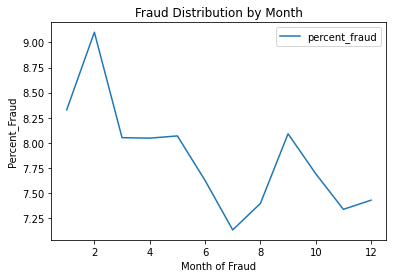

In [18]:
fraud_by_time_percent.plot(x = 'month', y = 'percent_fraud')
plt.xlabel('Month of Fraud')
plt.ylabel('Percent_Fraud')
plt.title('Fraud Distribution by Month')
plt.show()

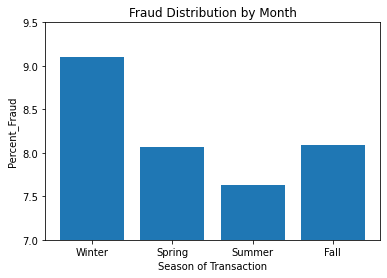

In [19]:
plt.bar(x = fraud_by_time_percent['Seasons'], height = fraud_by_time_percent['percent_fraud'])
plt.xlabel('Season of Transaction')
plt.ylabel('Percent_Fraud')
plt.title('Fraud Distribution by Month')
plt.ylim(7, 9.5)
plt.show()

## Feature Engineering

#### Convert the column invoice_date to date time format on both the invoice train and invoice test

In [20]:
for df in [invoice_train,invoice_test]:
    df['invoice_date'] = pd.to_datetime(df['invoice_date'])
    df['month'] = df['invoice_date'].dt.month

#### Encode labels in categorical column

In [21]:
d = {"ELEC" : 0, "GAZ" : 1}
invoice_train['counter_type'] = invoice_train['counter_type'].map(d)
invoice_test['counter_type'] = invoice_test['counter_type'].map(d)

#### Calculating Total Consumption Metrics - Across Customer's Lifetime

In [22]:
invoice_train['total_consumption'] = invoice_train['consommation_level_1'] + invoice_train['consommation_level_2'] + invoice_train['consommation_level_3'] + invoice_train['consommation_level_4']
invoice_test['total_consumption'] = invoice_test['consommation_level_1'] + invoice_test['consommation_level_2'] + invoice_test['consommation_level_3'] + invoice_test['consommation_level_4']

#### Converting categorical columns to int for model

In [23]:
client_train['client_catg'] = client_train['client_catg'].astype(int)
client_train['disrict'] = client_train['disrict'].astype(int)

client_test['client_catg'] = client_test['client_catg'].astype(int)
client_test['disrict'] = client_test['disrict'].astype(int)

#### Generating Features - Min, Max, Std, Mean, Range for Numerical Features

In [24]:
def aggregate_by_client_id(invoice_data):
    
    invoice_data['days_between_transactions'] = invoice_data.sort_values(['client_id', 'invoice_date'], 
                                                                         ascending = True).groupby('client_id')['invoice_date'].diff().dt.days.reset_index(drop = True)
    
    invoice_data['index_delta'] = invoice_data['new_index'] - invoice_data['old_index']
    
    aggs = {}
    aggs['consommation_level_1'] = ['mean', 'max', 'std', 'min', 'sum']
    aggs['consommation_level_2'] = ['mean', 'max', 'std', 'min', 'sum']
    aggs['consommation_level_3'] = ['mean', 'max', 'std', 'min', 'sum']
    aggs['consommation_level_4'] = ['mean', 'max', 'std', 'min', 'sum']
    aggs['months_number'] = ['mean', 'max', 'std', 'min']
    aggs['total_consumption'] = ['mean', 'max', 'std', 'min', 'sum']
    aggs['days_between_transactions'] = ['mean', 'max', 'std', 'min']
    aggs['index_delta'] = ['mean', 'max', 'std', 'min']
    
    aggs['counter_type'] = ['nunique']
    aggs['counter_number'] = ['nunique']
    aggs['reading_remarque'] = ['nunique']
    aggs['counter_coefficient'] = ['nunique']
    
    agg_trans = invoice_data.groupby(['client_id']).agg(aggs)
    agg_trans.columns = ['_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)
    
    features = ['consommation_level_1', 'consommation_level_2', 'consommation_level_3', 'consommation_level_4',
               'months_number', 'total_consumption', 'days_between_transactions', 'index_delta']
    
    for cols in features:
        agg_trans[cols + '_range'] = agg_trans[cols + '_max'] - agg_trans[cols + '_min']
        agg_trans[cols + '_std_over_mean'] = agg_trans[cols + '_std'] / agg_trans[cols + '_mean']
    
    spend_features = ['consommation_level_1', 'consommation_level_2', 'consommation_level_3', 'consommation_level_4', 
                      'total_consumption']
    
    metrics = ['mean', 'max', 'min', 'sum', 'range']
    
    for cols in spend_features:
        agg_trans[cols + '_mean_per_billing_cycle'] = agg_trans[cols + '_mean'] / agg_trans['days_between_transactions_mean']
        agg_trans[cols + '_max_per_billing_cycle'] = agg_trans[cols + '_max'] / agg_trans['days_between_transactions_mean']
        agg_trans[cols + '_min_per_billing_cycle'] = agg_trans[cols + '_min'] / agg_trans['days_between_transactions_mean']
        agg_trans[cols + '_sum_per_billing_cycle'] = agg_trans[cols + '_sum'] / agg_trans['days_between_transactions_mean']
        agg_trans[cols + '_range_per_billing_cycle'] = agg_trans[cols + '_range'] / agg_trans['days_between_transactions_mean']
    
    billing_cycle_cols = agg_trans.columns[[x.endswith('_per_billing_cycle') for x in agg_trans.columns]].to_list()
    
    for cols in billing_cycle_cols:
        agg_trans[cols] = [0 if math.isinf(x) == True else x for x in agg_trans[cols]]
    
    df = (invoice_data.groupby('client_id')
            .size()
            .reset_index(name='{}transactions_count'.format('1')))
    
    return pd.merge(df, agg_trans, on = 'client_id', how = 'left')

#### Group invoice data by client_id

In [25]:
agg_train = aggregate_by_client_id(invoice_train)
agg_test = aggregate_by_client_id(invoice_test)

In [26]:
print(agg_train.shape)
agg_train.head()

(135493, 84)


,client_id,1transactions_count,consommation_level_1_mean,consommation_level_1_max,consommation_level_1_std,consommation_level_1_min,consommation_level_1_sum,consommation_level_2_mean,consommation_level_2_max,consommation_level_2_std,...,consommation_level_4_mean_per_billing_cycle,consommation_level_4_max_per_billing_cycle,consommation_level_4_min_per_billing_cycle,consommation_level_4_sum_per_billing_cycle,consommation_level_4_range_per_billing_cycle,total_consumption_mean_per_billing_cycle,total_consumption_max_per_billing_cycle,total_consumption_min_per_billing_cycle,total_consumption_sum_per_billing_cycle,total_consumption_range_per_billing_cycle
0,train_Client_0,35,352.400000,1200,310.343472,38,12334,10.571429,186,43.568935,...,0.000000,0.000000,0.0,0.000000,0.000000,2.518063,9.615181,0.263620,88.132218,9.351561
1,train_Client_1,37,557.540541,1207,197.935960,190,20629,0.000000,0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,4.085377,8.844291,1.392225,151.158966,7.452066
2,train_Client_10,18,798.611111,2400,513.841374,188,14375,37.888889,682,160.748942,...,0.000000,0.000000,0.0,0.000000,0.000000,2.889758,10.647023,0.649461,52.015647,9.997561
3,train_Client_100,20,1.200000,15,3.607011,0,24,0.000000,0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.008559,0.106982,0.000000,0.171171,0.106982
4,train_Client_1000,14,663.714286,800,224.831365,124,9292,104.857143,400,167.155320,...,0.301127,3.133123,0.0,4.215773,3.133123,7.567418,19.536909,1.017035,105.943849,18.519874


#### Merge aggregated data with client dataset

In [27]:
train = pd.merge(client_train, agg_train, on='client_id', how='left')
test = pd.merge(client_test, agg_test, on='client_id', how='left')

In [28]:
train.head()

,disrict,client_id,client_catg,region,creation_date,target,1transactions_count,consommation_level_1_mean,consommation_level_1_max,consommation_level_1_std,...,consommation_level_4_mean_per_billing_cycle,consommation_level_4_max_per_billing_cycle,consommation_level_4_min_per_billing_cycle,consommation_level_4_sum_per_billing_cycle,consommation_level_4_range_per_billing_cycle,total_consumption_mean_per_billing_cycle,total_consumption_max_per_billing_cycle,total_consumption_min_per_billing_cycle,total_consumption_sum_per_billing_cycle,total_consumption_range_per_billing_cycle
0,60,train_Client_0,11,101,31/12/1994,0.0,35,352.400000,1200,310.343472,...,0.000000,0.000000,0.0,0.000000,0.000000,2.518063,9.615181,0.263620,88.132218,9.351561
1,69,train_Client_1,11,107,29/05/2002,0.0,37,557.540541,1207,197.935960,...,0.000000,0.000000,0.0,0.000000,0.000000,4.085377,8.844291,1.392225,151.158966,7.452066
2,62,train_Client_10,11,301,13/03/1986,0.0,18,798.611111,2400,513.841374,...,0.000000,0.000000,0.0,0.000000,0.000000,2.889758,10.647023,0.649461,52.015647,9.997561
3,69,train_Client_100,11,105,11/07/1996,0.0,20,1.200000,15,3.607011,...,0.000000,0.000000,0.0,0.000000,0.000000,0.008559,0.106982,0.000000,0.171171,0.106982
4,62,train_Client_1000,11,303,14/10/2014,0.0,14,663.714286,800,224.831365,...,0.301127,3.133123,0.0,4.215773,3.133123,7.567418,19.536909,1.017035,105.943849,18.519874


#### Grouping Transactions By Electricity & Gas

In [29]:
electricity_train = aggregate_by_client_id(invoice_train[invoice_train['counter_type'] == 0])
electricity_train = electricity_train.add_prefix('electricity_')

electricity_test = aggregate_by_client_id(invoice_test[invoice_test['counter_type'] == 0])
electricity_test = electricity_test.add_prefix('electricity_')

gas_train = aggregate_by_client_id(invoice_train[invoice_train['counter_type'] == 1])
gas_train = gas_train.add_prefix('gas_')

gas_test = aggregate_by_client_id(invoice_test[invoice_test['counter_type'] == 1])
gas_test = gas_test.add_prefix('gas_')

In [30]:
electricity_train.rename(columns = {'electricity_client_id' : 'client_id'}, inplace = True)
electricity_test.rename(columns = {'electricity_client_id' : 'client_id'}, inplace = True)

gas_train.rename(columns = {'gas_client_id' : 'client_id'}, inplace = True)
gas_test.rename(columns = {'gas_client_id' : 'client_id'}, inplace = True)

In [31]:
train = pd.merge(train, electricity_train, on='client_id', how='left')
train = pd.merge(train, gas_train, on='client_id', how='left')

test = pd.merge(test, electricity_test, on='client_id', how='left')
test = pd.merge(test, gas_test, on='client_id', how='left')

#### Time Metrics - Lifetime

In [32]:
def time_features(invoice_data):

    time_aggregated = invoice_data.groupby(['client_id'], as_index = False).agg({'invoice_date' : ['min', 'max']})
    time_aggregated.columns = ['_'.join(col).strip() for col in time_aggregated.columns.values]

    time_aggregated['customer_lifetime_months'] = (time_aggregated['invoice_date_max'] - time_aggregated['invoice_date_min']).dt.days/30
    
    current_time = datetime.datetime.now()
    
    time_aggregated['time_since_first_transaction_months'] = (current_time - time_aggregated['invoice_date_min']).dt.days/30
    time_aggregated['time_since_last_transaction_months'] = (current_time - time_aggregated['invoice_date_max']).dt.days/30
    
    return time_aggregated

In [33]:
time_features_train = time_features(invoice_train)
time_features_test = time_features(invoice_test)

In [34]:
train = pd.merge(train, time_features_train, left_on='client_id', right_on = 'client_id_', how = 'inner')
train.drop(['client_id_'], axis = 1, inplace = True)

test = pd.merge(test, time_features_test, left_on='client_id', right_on = 'client_id_', how = 'inner')
test.drop(['client_id_'], axis = 1, inplace = True)

In [35]:
def spend_features_over_time(data):
    
    data['transactions_per_month'] = data['1transactions_count'] / data['customer_lifetime_months']
    data['level_1_spend_per_month'] = data['consommation_level_1_sum'] / data['customer_lifetime_months']
    data['overall_spend_per_month'] = data['total_consumption_sum'] / data['customer_lifetime_months']
    
    cols = ['transactions_per_month', 'level_1_spend_per_month', 'overall_spend_per_month']
    
    for cols in cols:
        data[cols] = [0 if math.isinf(x) == True else x for x in data[cols]]
    
    return data

In [36]:
train = spend_features_over_time(train)
test = spend_features_over_time(test)

In [37]:
def first_transaction_features(data, client_train):
    
    first_transaction_per_client = data.groupby(['client_id'], as_index = False)['invoice_date'].min().rename(columns 
                                                                                                                  = {'invoice_date': 
                                                                                                                     'first_transaction_date'})
    first_transaction_per_client = first_transaction_per_client.merge(client_train[['client_id', 'creation_date']], how = 'inner', on = 'client_id')
    first_transaction_per_client['creation_date'] = pd.to_datetime(first_transaction_per_client['creation_date'])
    first_transaction_per_client['months_from_account_creation_to_first_transaction'] = (first_transaction_per_client['first_transaction_date'] 
                                                                                         - first_transaction_per_client['creation_date']).dt.days/30
    
    first_transaction_per_client.drop(columns = ['first_transaction_date', 'creation_date'], inplace = True)
    
    return first_transaction_per_client

In [38]:
first_transaction_train = first_transaction_features(invoice_train, client_train)
first_transaction_test = first_transaction_features(invoice_test, client_test)

In [39]:
train = pd.merge(train, first_transaction_train, how = 'inner', on = 'client_id')
test = pd.merge(test, first_transaction_test, how = 'inner', on = 'client_id')

#### Seasonality of Fraud

In [40]:
def month_of_fraud(invoice_data):
    
    df = invoice_data[['client_id', 'month']].drop_duplicates()
    
    df['Seasons'] = np.where(df['month'] <= 2, 'Winter', 
                                           np.where(df['month'] <= 5, 'Spring',
                                                   np.where(df['month'] <= 8, 'Summer',
                                                           np.where(df['month'] <= 11, 'Fall', 'Winter'))))
    
    df['month'] = df['month'].astype('category')
    
    df_cat = pd.get_dummies(df[['month', 'Seasons']], drop_first = True, prefix = 'month', prefix_sep = '_')
    output = df.merge(df_cat, how = 'inner', left_index = True, right_index = True)
    output.drop(columns = ['month', 'Seasons'], inplace = True)
    return output.groupby(['client_id'], as_index = False).max()

In [41]:
invoice_train_month = month_of_fraud(invoice_train)
invoice_test_month = month_of_fraud(invoice_test)

In [42]:
train = train.merge(invoice_train_month, how = 'inner', on = 'client_id')
test = test.merge(invoice_test_month, how = 'inner', on = 'client_id')

#### Basket Size Features

In [43]:
train['avg_transaction_value'] = train['total_consumption_sum'] / train['1transactions_count']
test['avg_transaction_value'] = test['total_consumption_sum'] / test['1transactions_count']

#### Dropping Unwanted / Redundant Columns

In [44]:
categorical_columns = ['disrict', 'client_catg']

for cols in categorical_columns:
    train[cols] = train[cols].astype('category')
    train_1 = pd.get_dummies(train[cols], drop_first = True, prefix = cols)
    train = train.merge(train_1, how = 'inner', left_index = True, right_index = True)

for cols in categorical_columns:
    test[cols] = test[cols].astype('category')
    test_1 = pd.get_dummies(test[cols], drop_first = True, prefix = cols)
    test = test.merge(test_1, how = 'inner', left_index = True, right_index = True)

In [45]:
train.shape, test.shape

((135493, 284), (58069, 283))

In [46]:
train.head()

,disrict,client_id,client_catg,region,creation_date,target,1transactions_count,consommation_level_1_mean,consommation_level_1_max,consommation_level_1_std,...,month_12,month_Spring,month_Summer,month_Winter,avg_transaction_value,disrict_62,disrict_63,disrict_69,client_catg_12,client_catg_51
0,60,train_Client_0,11,101,31/12/1994,0.0,35,352.400000,1200,310.343472,...,1,1,1,1,362.971429,0,0,0,0,0
1,69,train_Client_1,11,107,29/05/2002,0.0,37,557.540541,1207,197.935960,...,0,1,1,1,557.540541,0,0,1,0,0
2,62,train_Client_10,11,301,13/03/1986,0.0,18,798.611111,2400,513.841374,...,0,1,1,1,836.500000,1,0,0,0,0
3,69,train_Client_100,11,105,11/07/1996,0.0,20,1.200000,15,3.607011,...,0,1,1,1,1.200000,0,0,1,0,0
4,62,train_Client_1000,11,303,14/10/2014,0.0,14,663.714286,800,224.831365,...,1,1,1,1,922.642857,1,0,0,0,0


In [47]:
sub_client_id = test['client_id']
drop_columns = ['client_id', 'creation_date', 'disrict', 'client_catg', 'region', 'invoice_date_min', 'invoice_date_max']

for col in drop_columns:
    if col in train.columns:
        train.drop([col], axis=1, inplace=True)
    if col in test.columns:
        test.drop([col], axis=1, inplace=True)

# Train Test Split

In [48]:
train.columns

Index(['target', '1transactions_count', 'consommation_level_1_mean',
       'consommation_level_1_max', 'consommation_level_1_std',
       'consommation_level_1_min', 'consommation_level_1_sum',
       'consommation_level_2_mean', 'consommation_level_2_max',
       'consommation_level_2_std',
       ...
       'month_12', 'month_Spring', 'month_Summer', 'month_Winter',
       'avg_transaction_value', 'disrict_62', 'disrict_63', 'disrict_69',
       'client_catg_12', 'client_catg_51'],
      dtype='object', length=277)

In [49]:
X = train.drop(columns=['target'])
y = train['target']

X = X.fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

X_train_better = X_train
y_train_better = y_train

# Modelling - LGBM Classifier

In [50]:
clf_lgbm = LGBMClassifier(criterion = 'gini',
                            splitter = 'best',
                            n_estimators = 475,
                            learning_rate = 0.014434843245570792,
                            max_depth = 25,
                            num_leaves = 65,
                            bagging_fraction = 0.45359952491310546,
                            feature_fraction = 0.5362732430623661,
                            min_child_samples = 149,
                            min_split_gain = 0.06430401426692142,
                            class_weight = None,
                          n_jobs = -1)

clf_lgbm.fit(X_train, y_train)

LGBMClassifier(bagging_fraction=0.45359952491310546, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, criterion='gini',
               feature_fraction=0.5362732430623661, importance_type='split',
               learning_rate=0.014434843245570792, max_depth=25,
               min_child_samples=149, min_child_weight=0.001,
               min_split_gain=0.06430401426692142, n_estimators=475, n_jobs=-1,
               num_leaves=65, objective=None, random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, splitter='best', subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [51]:
print(classification_report(y_test, clf_lgbm.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97     38366
         1.0       0.52      0.03      0.06      2282

    accuracy                           0.94     40648
   macro avg       0.73      0.51      0.51     40648
weighted avg       0.92      0.94      0.92     40648



In [52]:
print(classification_report(y_train, clf_lgbm.predict(X_train)))

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97     89561
         1.0       0.95      0.12      0.21      5284

    accuracy                           0.95     94845
   macro avg       0.95      0.56      0.59     94845
weighted avg       0.95      0.95      0.93     94845



In [53]:
roc_auc_score(y_test, clf_lgbm.predict(X_test))

0.5146963927809475

In [54]:
roc_auc_score(y_train, clf_lgbm.predict(X_train))

0.5600920738529459

In [55]:
predicted_train = pd.DataFrame(clf_lgbm.predict(X_train))
actual_predicted_comparison = pd.merge(pd.DataFrame(y_train), predicted_train, how = 'inner', left_index = True,
                                       right_index = True)

,target,0
83538,0.0,0.0
16334,0.0,0.0
16900,0.0,0.0
79422,0.0,0.0
72739,0.0,0.0


In [58]:
actual_predicted_comparison.rename(columns = {'target': 'actual', 0:'predicted'}, inplace = True)

In [59]:
actual_predicted_comparison.head()

,actual,predicted
83538,0.0,0.0
16334,0.0,0.0
16900,0.0,0.0
79422,0.0,0.0
72739,0.0,0.0


In [55]:
preds = clf_lgbm.predict_proba(test)[:,1]
preds = pd.DataFrame(preds, columns=['target'])
preds.head()

submission = pd.DataFrame(
    {
        'client_id': sub_client_id,
        'target': preds['target']
    }
)

submission.head()

submission.to_csv('submission_lgbm.csv', index=False)

### Hyperparameter Tuning - Using Optuna with a Random Search to Speed up Training

In [50]:
def objective_dt(trial, X, y):
    param_grid = { 
    
        'criterion' : trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'splitter' : trial.suggest_categorical('splitter', ['best', 'random']),
        'n_estimators' : trial.suggest_int('n_estimators', 5, 500, steps = 5),
        'learning_rate' : trial.suggest_uniform('learning_rate', 0.001, 0.2),
        'max_depth' : trial.suggest_int('max_depth', 5, 500, steps = 5),
        'num_leaves':trial.suggest_int('num_leaves', 5, 500, steps = 10),
        'bagging_fraction' : trial.suggest_uniform('bagging_fraction', 0.001, 0.95),
        'feature_fraction' : trial.suggest_uniform('feature_fraction', 0.001, 0.95),
        'min_child_samples' : trial.suggest_int('min_child_samples', 25, 5000),
        'min_split_gain': trial.suggest_uniform('min_split_gain', 0.001, 0.1),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
        'random_state' : 42
}

In [ ]:
# 'criterion': 'gini',
#  'splitter': 'best',
#  'n_estimators': 315,
#  'learning_rate': 0.01796848572520029,
#  'max_depth': 100,
#  'num_leaves': 45,
#  'bagging_fraction': 0.1631029249420016,
#  'feature_fraction': 0.737835998796638,
#  'min_child_samples': 136,
#  'min_split_gain': 0.03223874112537372,
#  'class_weight': None

In [63]:
# param_grid = { 
#     'n_estimators' : randint(5, 500),
#     'learning_rate' : uniform(0.001, 0.2),
#     'max_depth' : randint(2, 100),
#     'bagging_fraction' : uniform(0.001, 0.95),
#     'feature_fraction' : uniform(0.001, 0.95),
#     'min_child_samples' : randint(25, 5000),
#     'min_split_gain': uniform(0.001, 0.1)
# }

clf_lgbm = RandomizedSearchCV(LGBMClassifier(class_weight = 'balanced'), param_distributions = param_grid, cv = 5, n_jobs = -1, 
                        scoring = 'roc_auc', verbose = True, n_iter = 5000)

clf_lgbm = LGBMClassifier(bagging_fraction = 0.05838962405614604,
                          feature_fraction = 0.610643708814882,
                          learning_rate = 0.01569044751095259,
                          max_depth = 91,
                          min_child_samples = 1242,
                          min_split_gain = 0.01427746828862676,
                          n_estimators = 498,
                          n_jobs = -1)

clf_lgbm.fit(X_train, y_train)

LGBMClassifier(bagging_fraction=0.05838962405614604, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.610643708814882, importance_type='split',
               learning_rate=0.01569044751095259, max_depth=91,
               min_child_samples=1242, min_child_weight=0.001,
               min_split_gain=0.01427746828862676, n_estimators=498, n_jobs=-1,
               num_leaves=31, objective=None, random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [64]:
# clf_lgbm.best_params_

In [65]:
# clf_lgbm.best_score_

In [66]:
print(classification_report(y_test, clf_lgbm.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     38348
         1.0       0.58      0.03      0.05      2300

    accuracy                           0.94     40648
   macro avg       0.76      0.51      0.51     40648
weighted avg       0.92      0.94      0.92     40648



In [67]:
print(classification_report(y_train, clf_lgbm.predict(X_train)))

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97     89579
         1.0       0.80      0.04      0.08      5266

    accuracy                           0.95     94845
   macro avg       0.88      0.52      0.53     94845
weighted avg       0.94      0.95      0.92     94845



In [68]:
# clf_lgbm = clf_lgbm.best_estimator_

In [69]:
roc_auc_score(y_test, clf_lgbm.predict(X_test))

0.5122654319028032

In [70]:
roc_auc_score(y_train, clf_lgbm.predict(X_train))

0.5204029943724561

# Modelling - Random Forest

In [50]:
param_grid = {
    'n_estimators' : randint(2, 5000),
    'max_depth' : randint(2, 500),
    'min_samples_split' : randint(2, 5000),
    'min_samples_leaf' : randint(2, 5000),
    'max_samples' : uniform(0.01, 0.9),
    'max_features': ['auto', 'sqrt']
    }

clf_rf = RandomizedSearchCV(RandomForestClassifier(class_weight = 'balanced'), param_distributions = param_grid, 
                            n_jobs = -1, cv = 3, scoring = 'roc_auc', verbose = True, n_iter = 1000)

# clf_rf = RandomForestClassifier(n_estimators = 75,
#                                min_samples_split = 50,
#                                min_samples_leaf = 10,
#                                max_samples = 0.3,
#                                max_features = 'sqrt',
#                                max_depth = 30,
#                               n_jobs = -1)

clf_rf.fit(X_train_better, y_train_better)

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done 290 tasks      | elapsed: 24.2min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 52.7min
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed: 88.7min
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed: 136.5min
[Parallel(n_jobs=-1)]: Done 2290 tasks      | elapsed: 189.5min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 256.3min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
         

In [51]:
clf_rf.best_params_

{'max_depth': 171,
 'max_features': 'auto',
 'max_samples': 0.809694116779066,
 'min_samples_leaf': 118,
 'min_samples_split': 65,
 'n_estimators': 4564}

In [52]:
clf_rf.best_score_

0.8256263129715026

In [53]:
print(classification_report(y_test, clf_rf.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.98      0.80      0.88     38348
         1.0       0.18      0.71      0.28      2300

    accuracy                           0.80     40648
   macro avg       0.58      0.76      0.58     40648
weighted avg       0.93      0.80      0.85     40648



In [54]:
print(classification_report(y_train_better, clf_rf.predict(X_train_better)))

              precision    recall  f1-score   support

         0.0       0.99      0.81      0.89     89579
         1.0       0.20      0.80      0.31      5266

    accuracy                           0.81     94845
   macro avg       0.59      0.80      0.60     94845
weighted avg       0.94      0.81      0.86     94845



In [55]:
roc_auc_score(y_test, clf_rf.predict(X_test))

0.7563856399744219

In [56]:
roc_auc_score(y_train_better, clf_rf.predict(X_train_better))

0.8024338282549852

In [61]:
test = test.fillna(0)
test.replace([np.inf, -np.inf], 0, inplace=True)

preds = clf_rf.predict_proba(test)[:,1]
preds = pd.DataFrame(preds, columns=['target'])
preds.head()

submission = pd.DataFrame(
    {
        'client_id': sub_client_id,
        'target': preds['target']
    }
)

submission.head()

submission.to_csv('submission_rf.csv', index=False)

## Make Predictions on test set

In [71]:
level_0 = list()
level_0.append(('lgbm', clf_lgbm))
level_0.append(('rf', clf_rf))

In [72]:
stacked_model = StackingClassifier(estimators = level_0, final_estimator = LogisticRegression(), cv = 10)

In [73]:
sclf = stacked_model.fit(X_train, y_train)

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 290 tasks      | elapsed: 25.1min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 52.7min
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed: 89.3min
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed: 131.9min
[Parallel(n_jobs=-1)]: Done 2290 tasks      | elapsed: 191.2min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 260.0min finished
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 290 tasks      | elapsed: 21.3min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 41.4min
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed: 68.7min
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed: 103.2min
[Parallel(n_jobs=-1)]: Done 2290 tasks      | elapsed: 145.8min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 197.4min finished


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 290 tasks      | elapsed: 22.1min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 46.3min
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed: 80.5min
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed: 127.2min
[Parallel(n_jobs=-1)]: Done 2290 tasks      | elapsed: 358.7min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 668.5min finished


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 290 tasks      | elapsed: 24.4min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 49.5min
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed: 83.7min
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed: 120.0min
[Parallel(n_jobs=-1)]: Done 2290 tasks      | elapsed: 163.6min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 228.7min finished


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 290 tasks      | elapsed: 57.1min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 86.3min
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed: 115.0min
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed: 152.1min
[Parallel(n_jobs=-1)]: Done 2290 tasks      | elapsed: 193.4min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 250.0min finished


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 290 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 39.1min
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed: 71.1min
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed: 113.5min
[Parallel(n_jobs=-1)]: Done 2290 tasks      | elapsed: 157.7min


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 290 tasks      | elapsed: 21.7min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 48.1min
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed: 80.7min
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed: 116.9min
[Parallel(n_jobs=-1)]: Done 2290 tasks      | elapsed: 163.2min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 215.4min finished


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 290 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 42.2min
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed: 74.2min
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed: 111.8min
[Parallel(n_jobs=-1)]: Done 2290 tasks      | elapsed: 157.7min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 209.1min finished


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 290 tasks      | elapsed: 20.1min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 43.9min
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed: 72.1min
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed: 113.9min
[Parallel(n_jobs=-1)]: Done 2290 tasks      | elapsed: 153.9min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 205.2min finished


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 290 tasks      | elapsed: 18.9min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 39.0min
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed: 71.5min
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed: 107.8min
[Parallel(n_jobs=-1)]: Done 2290 tasks      | elapsed: 148.5min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 208.3min finished


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 290 tasks      | elapsed: 22.9min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 51.5min
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed: 90.1min
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed: 129.8min
[Parallel(n_jobs=-1)]: Done 2290 tasks      | elapsed: 175.0min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 226.1min finished


In [74]:
roc_auc_score(y_train_better, sclf.predict(X_train_better))

0.5609247411024131

In [75]:
roc_auc_score(y_test, sclf.predict(X_test))

0.5410879542496406

In [230]:
preds = clf_lgbm.predict_proba(test)[:,1]
preds = pd.DataFrame(preds, columns=['target'])
preds.head()

submission = pd.DataFrame(
    {
        'client_id': sub_client_id,
        'target': preds['target']
    }
)

submission.head()

submission.to_csv('submission_lgbm.csv', index=False)

In [ ]:
test = test.fillna(0)

preds = clf_rf.predict_proba(test)[:,1]
preds = pd.DataFrame(preds, columns=['target'])
preds.head()

submission = pd.DataFrame(
    {
        'client_id': sub_client_id,
        'target': preds['target']
    }
)

submission.head()

submission.to_csv('submission_rf.csv', index=False)

In [76]:
test.replace([np.inf, -np.inf], 0, inplace=True)
test.fillna(0, inplace = True)

preds = sclf.predict_proba(test)[:,1]
preds = pd.DataFrame(preds, columns=['target'])
preds.head()

submission = pd.DataFrame(
    {
        'client_id': sub_client_id,
        'target': preds['target']
    }
)

submission.head()

submission.to_csv('submission_stacked.csv', index=False)